<a href="https://colab.research.google.com/github/jerryjerry9/FRI_ML/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
with open('/content/drive/MyDrive/ml_data/hw03/data_theta_profile.pkl', 'rb') as f:
    profile =  pickle.load(f)
with open('/content/drive/MyDrive/ml_data/hw03/data_inversion_label.pkl', 'rb') as f:
    label =  pickle.load(f)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(profile, label, test_size=0.25, random_state=50)

In [61]:
print(x_train.shape)
print(x_test.shape)
print(x_train[5,:])

(7062, 27)
(2355, 27)
[ 0.99758521  1.07654949  0.19856601 -0.38110674 -0.86703467 -0.70393093
 -0.3751108  -0.19785091 -0.27858209 -0.14469166  0.0289484  -0.0873394
 -0.4938623  -0.43380125 -0.13330249 -0.01737169 -0.15480578 -0.38352207
 -0.60656526 -0.55660048 -0.76254206 -0.91648483 -0.9814221  -0.84092979
 -0.72756278 -0.67665287 -0.6608814 ]


In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [14]:
print('After scaling')
print(x_train[5,:])

After scaling
[ 0.99758521  1.07654949  0.19856601 -0.38110674 -0.86703467 -0.70393093
 -0.3751108  -0.19785091 -0.27858209 -0.14469166  0.0289484  -0.0873394
 -0.4938623  -0.43380125 -0.13330249 -0.01737169 -0.15480578 -0.38352207
 -0.60656526 -0.55660048 -0.76254206 -0.91648483 -0.9814221  -0.84092979
 -0.72756278 -0.67665287 -0.6608814 ]


In [9]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = TrainData(torch.FloatTensor(x_train), 
                       torch.FloatTensor(y_train))
test_data = TrainData(torch.FloatTensor(x_test), 
                       torch.FloatTensor(y_test))

In [10]:
train_loader = DataLoader(dataset=train_data, batch_size=32)
test_loader = DataLoader(dataset=test_data, batch_size=32)

In [39]:
# 定義類神經網路模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 建立類神經網路各層
        self.layer_1 = nn.Linear(27, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
    def forward(self, inputs):
        # 定義資料如何通過類神經網路各層
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [40]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [41]:
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=27, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [42]:
# 損失函數
loss_fn = nn.BCEWithLogitsLoss()
# 學習優化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [43]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum
    return acc

In [44]:
# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)
    #num_batches = len(dataloader)
    # 將模型設定為訓練模式
    model.train()
    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)
        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y.unsqueeze(1)) # 計算損失值（loss）
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數


In [45]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()

            # 計算預測正確數量的加總值
            correct += binary_acc(pred, y.unsqueeze(1)).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss , correct*100


In [46]:
# 設定 epochs 數
epochs = 50
st_time = time.time()
total_trainloss = np.zeros((epochs)) 
total_testloss = np.zeros((epochs)) 
total_acc = np.zeros((epochs)) 
# 開始訓練模型
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    trainloss,acc1 = test(train_loader, model, loss_fn)
    testloss,acc = test(test_loader, model, loss_fn)
    total_trainloss[t] = trainloss
    total_testloss[t] = testloss
    total_acc[t] = acc
cost_time = time.time() - st_time
print('Total time use',cost_time)
#acc_diff = total_acc[29] - 80.6
#trainloss_diff = total_trainloss[29] - 0.5264
#testloss_diff = total_testloss[29] - 0.5513
#time_diff = cost_time - 486.8
#print('acc diff',acc_diff)
#print('train loss diff',trainloss_diff)
#print('test loss diff',testloss_diff )
#print('time diff',time_diff)
#print('done')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 60.3%, Avg loss: 0.669054 

Test Error: 
 Accuracy: 61.6%, Avg loss: 0.662018 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 63.7%, Avg loss: 0.649105 

Test Error: 
 Accuracy: 65.0%, Avg loss: 0.641129 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 65.9%, Avg loss: 0.634849 

Test Error: 
 Accuracy: 66.2%, Avg loss: 0.626917 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 67.2%, Avg loss: 0.623556 

Test Error: 
 Accuracy: 67.1%, Avg loss: 0.615786 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.614295 

Test Error: 
 Accuracy: 68.2%, Avg loss: 0.606969 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 68.7%, Avg loss: 0.606608 

Test Error: 
 Accuracy: 69.4%, Avg loss: 0.599391 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.600016 

Test Error: 
 Accuracy: 69.9%, Avg loss: 0.5

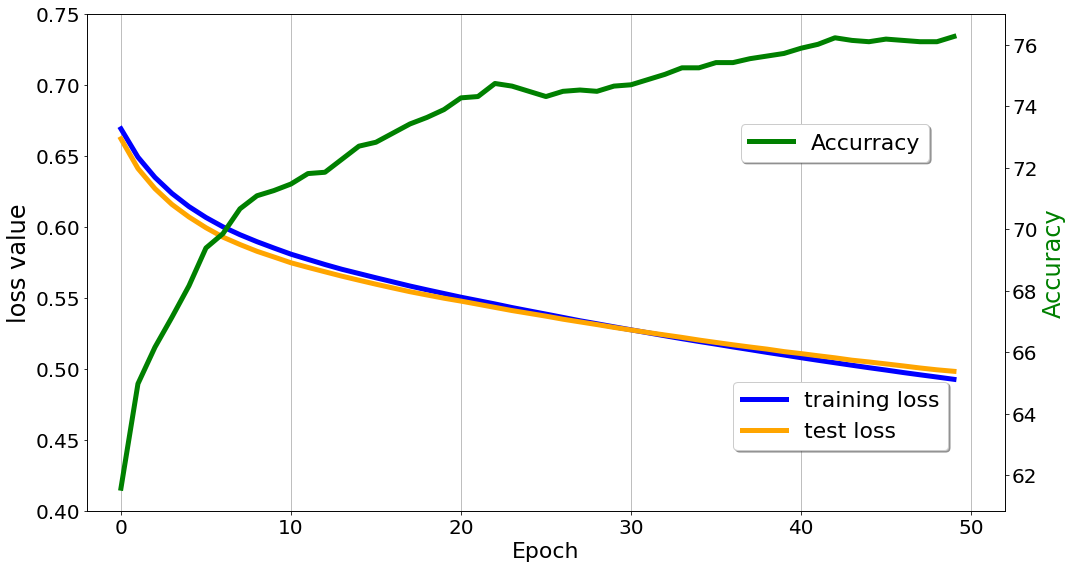

In [50]:
f,ax1= plt.subplots(figsize=(15,8))

ax1.plot(total_trainloss,linewidth=5,c='blue')
ax1.plot(total_testloss,linewidth=5,c='orange')
plt.legend(["training loss","test loss",],fontsize=22,shadow=True,loc=4,bbox_to_anchor=(0.95,0.1))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('loss value',fontsize=24)
ax1.set_xlabel('Epoch',color='k',fontsize=22)
ax1.grid(axis='x')
plt.axis([-2,52,0.4,0.75])


ax2 = ax1.twinx()
ax2.plot(total_acc,linewidth=5,c='green')
plt.ylabel('Accuracy',fontsize=24,c='green')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(["Accurracy"],fontsize=22,shadow=True,loc=2,bbox_to_anchor=(0.7,0.8))
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw03/loss_hw3.png',dpi=400)



In [52]:
model.eval()
pred_result = np.zeros((2355))
truth = np.zeros((2355))
for i in range(0,2355):
    x, y = test_data[i:i+1][0], test_data[i][1]
    pred = model(x)
    pred_result[i] = torch.round(torch.sigmoid(pred))
    truth[i] = y

In [53]:
hist_pred = np.histogram2d(pred_result,truth,bins=2)

In [54]:
nparray_h = hist_pred[0]
for i in range(0,2):
    print(nparray_h[:,i])

[408. 274.]
[ 285. 1388.]


In [59]:
classes = ['no inv','inv']

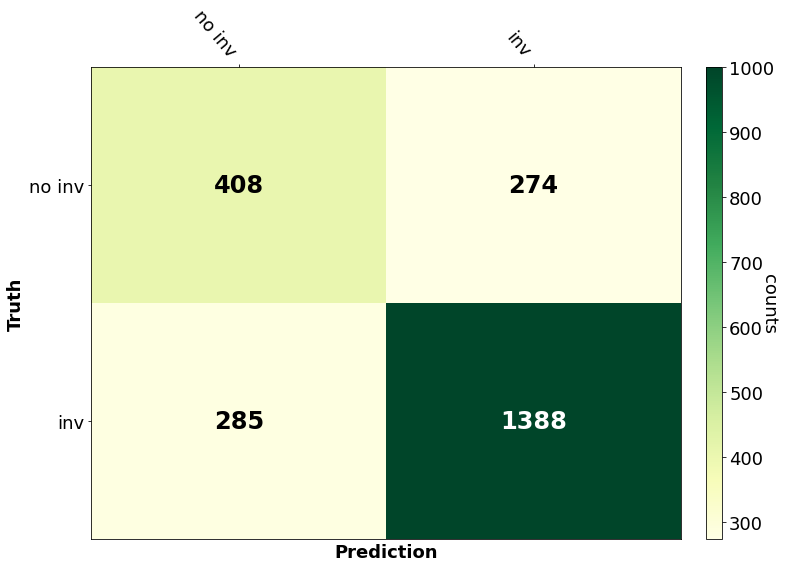

In [60]:
f,ax= plt.subplots(figsize=(11,8))
#ax.hist2d(pred_result, truth,bins=10,cmap='YlGn')
hitplot = ax.pcolormesh(nparray_h.T,cmap='YlGn',vmax=1000)
for xx in range(0,2):
  for yy in range(0,2):
    if nparray_h[xx,yy] > 500:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='w', size=24,fontweight='semibold',ha='center',va='center')
    else:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='k', size=24,fontweight='semibold',ha='center',va='center')
ax.invert_yaxis()
plt.ylabel('Truth',fontsize=18,fontweight='semibold',rotation=90)
plt.xlabel('Prediction',fontsize=18,fontweight='semibold')
plt.xticks(np.arange(0.5,2,1),classes,fontsize=18,rotation=310,horizontalalignment='right')
ax.xaxis.tick_top()
plt.yticks(np.arange(0.5,2,1),classes,fontsize=18)
cb = plt.colorbar(hitplot,aspect=30,fraction=0.03, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('counts', size=18,rotation=270)
plt.tight_layout()
plt.savefig('drive/MyDrive/ml_data/hw03/heatmap_hw3.png',dpi=400)

